<a href="https://colab.research.google.com/github/sumeet/chess-deep-learning/blob/main/chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
#!wget "https://database.lichess.org/standard/lichess_db_standard_rated_2017-02.pgn.zst"

In [ ]:
#!apt-get update && apt-get install zstd

In [ ]:
#!unzstd *.zst

lichess_db_standard_rated_2017-02.pgn.zst: 9289131923 bytes 


# Input and outputs

In [ ]:
try:
    from chess import pgn
except ImportError:    
    !pip install python-chess
    import chess
    from chess import pgn

import torch
import torch.nn.functional as F
from torch import tensor

import numpy as np


f = open('./drive/MyDrive/MLchess/elite.chess')

def board_to_tensor(board):
    pieces_order = ['pawn', 'knight', 'bishop', 'rook', 'queen', 'king']  # Chess piece types
    pieces = {name: i for i, name in enumerate(pieces_order)}
    tensor = torch.zeros((8, 8, 12), dtype=torch.float32)

    # Loop through all squares on the board
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            # Get piece type and color
            piece_type = chess.piece_name(piece.piece_type)
            color = piece.color

            # Calculate the coordinates
            row = square // 8
            col = square % 8

            # Calculate the depth index based on the piece type and color
            piece_index = pieces[piece_type] + (6 if color == chess.BLACK else 0)

            # Place the piece in the tensor
            tensor[row, col, piece_index] = 1

    # Flatten the tensor
    tensor = tensor.view(-1)

    # Append castling rights
    tensor = torch.cat((tensor, torch.tensor([
        int(board.has_kingside_castling_rights(chess.WHITE)),
        int(board.has_queenside_castling_rights(chess.WHITE)),
        int(board.has_kingside_castling_rights(chess.BLACK)),
        int(board.has_queenside_castling_rights(chess.BLACK)),
    ])))

    # Append en passant square
    if board.ep_square is not None:
        tensor = torch.cat((tensor, torch.tensor([board.ep_square])))
    else:
        tensor = torch.cat((tensor, torch.tensor([64])))  # Append 64 if there is no en passant square

    # Append white's turn
    tensor = torch.cat((tensor, torch.tensor([1 if board.turn == chess.WHITE else 0])))

    # Append is in check
    tensor = torch.cat((tensor, torch.tensor([0 if board.is_check() else -1])))

    return tensor

cache = {}
reverse_cache = {}
for i, src_file in enumerate('abcdefgh'):
    for j, src_rank in enumerate('12345678'):
        for k, dst_file in enumerate('abcdefgh'):
            for l, dst_rank in enumerate('12345678'):
                src_matrix = i*8+j
                dst_matrix = k*8+l
                src_move = src_file + src_rank 
                dst_move = dst_file + dst_rank
                reverse_cache[src_matrix] = src_move
                reverse_cache[dst_matrix] = dst_move
                cache[src_move + dst_move] = (
                    tensor(src_matrix, dtype=torch.long),
                    tensor(dst_matrix, dtype=torch.long))

def move_to_tensors(chess_move):
    return cache[chess_move[:4]]


input_tensors = []
output_src_tensors = []
output_dst_tensors = []
num_games = 0

for line in f:
    moves = line.split(",")
    winner = next(f).strip()
    if winner == "D":
        continue

    to_move = "W"

    board = chess.Board()
    for (i, move) in enumerate(moves):
        # (was made by winner)
        use_as_input = to_move == winner and i < len(moves)

        if use_as_input:
            input_tensors.append(board_to_tensor(board))

        move = move.strip()
        board.push_san(move)

        if use_as_input:
            (src, dst) = move_to_tensors(move)
            output_src_tensors.append(src)
            output_dst_tensors.append(dst)

        to_move = "W" if to_move == "B" else "B"

    num_games += 1

    if num_games % 1000 == 0:
        print(f'processed {num_games} games already')

    if num_games > 100_000:
        break


print(f'loaded {len(input_tensors)} input  total')

    
training_size = 50_000
training_size = len(input_tensors)
input_batch = torch.stack(input_tensors[:training_size])
output_src_batch = torch.stack(output_src_tensors[:training_size])
output_dst_batch = torch.stack(output_dst_tensors[:training_size])

# test_input = torch.stack(input_sequences[training_size:])
# test_output = torch.stack(output_sequences[training_size:])



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 4.2 MB/s eta 0:00:00
processed 1000 games already
processed 2000 games already
processed 3000 games already
processed 4000 games already
processed 5000 games already
processed 6000 games already
processed 7000 games already
processed 8000 games already
processed 9000 games already
processed 10000 games already
processed 11000 games already
processed 12000 games already
processed 13000 games already
processed 14000 games already
processed 15000 games already
processed 16000 games already
processed 17000 games already
processed 18000 games already
processed 19000 games already
processed 20000 games already
processed 21000 games already
loaded 773032 input  total


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class ChessMovePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_squares):
        super(ChessMovePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc_source = nn.Linear(hidden_dim, num_squares)
        self.fc_dest = nn.Linear(hidden_dim, num_squares)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        out_source = self.fc_source(out)
        out_dest = self.fc_dest(out)
        return out_source, out_dest


input_dim = 775
hidden_dim = 512
num_squares = 64
model = ChessMovePredictor(input_dim, hidden_dim, num_squares)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train Neural Network

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

num_epochs = 10_000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

dataset = TensorDataset(input_batch, output_src_batch, output_dst_batch)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

for epoch in range(num_epochs):
    for inputs, targets_source, targets_dest in dataloader:
        inputs = inputs.to(device)
        targets_source = targets_source.to(device)
        targets_dest = targets_dest.to(device)
    
        # Forward pass
        outputs_source, outputs_dest = model(inputs)
    
        loss_source = loss_fn(outputs_source, targets_source)
        loss_dest = loss_fn(outputs_dest, targets_dest)
    
        # Compute total loss
        loss = loss_source + loss_dest
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       

    if epoch % 50 == 0:
        filename = './drive/MyDrive/MLchess/checkpoint.pt'
        print(f'saving checkpoint to {filename}')
        torch.save(model.state_dict(), filename)  # Save the model checkpoint

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


saving checkpoint to ./drive/MyDrive/MLchess/checkpoint.pt
Epoch [1/10000], Loss: 5.8323
Epoch [2/10000], Loss: 6.0742
Epoch [3/10000], Loss: 5.1638
Epoch [4/10000], Loss: 5.4865
Epoch [5/10000], Loss: 5.0492
Epoch [6/10000], Loss: 5.1270
Epoch [7/10000], Loss: 5.3261
Epoch [8/10000], Loss: 4.2962
Epoch [9/10000], Loss: 4.9046
Epoch [10/10000], Loss: 4.7335
Epoch [11/10000], Loss: 4.4557
Epoch [12/10000], Loss: 3.6573
Epoch [13/10000], Loss: 4.1042
Epoch [14/10000], Loss: 3.8259
Epoch [15/10000], Loss: 4.2100
Epoch [16/10000], Loss: 5.2944
Epoch [17/10000], Loss: 4.5074
Epoch [18/10000], Loss: 4.5068
Epoch [19/10000], Loss: 4.1979
Epoch [20/10000], Loss: 3.5514
Epoch [21/10000], Loss: 3.9322
Epoch [22/10000], Loss: 3.7583
Epoch [23/10000], Loss: 3.4434
Epoch [24/10000], Loss: 4.1425
Epoch [25/10000], Loss: 4.2355
Epoch [26/10000], Loss: 4.0356
Epoch [27/10000], Loss: 4.4893
Epoch [28/10000], Loss: 4.0994
Epoch [29/10000], Loss: 3.4036
Epoch [30/10000], Loss: 3.8348
Epoch [31/10000], Lo

KeyboardInterrupt: ignored

# Spot check

In [ ]:
gamestr = """[Event "Rated Bullet game"]
[Site "https://lichess.org/G60KFAT0"]
[Date "2023.05.22"]
[White "smt2"]
[Black "salahd4d5"]
[Result "0-1"]
[UTCDate "2023.05.22"]
[UTCTime "00:52:33"]
[WhiteElo "1391"]
[BlackElo "1452"]
[WhiteRatingDiff "-5"]
[BlackRatingDiff "+30"]
[Variant "Standard"]
[TimeControl "120+1"]
[ECO "C50"]
[Opening "Italian Game: Giuoco Pianissimo, Normal"]
[Termination "Normal"]
[Annotator "lichess.org"]

1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. d3 Nf6 { C50 Italian Game: Giuoco Pianissimo, Normal } 5. Be3 Bxe3 6. fxe3 O-O 7. O-O d6 8. Qd2 Be6 9. Na3 Ng4 10. h3 Nf6 11. Rf2 Bd7 12. Raf1 Ne7 13. Ng5 h6 14. Nf3 Ng6 15. Nh2 a5 16. Qe2 c6 17. Rf3 b5 18. Bb3 a4 19. Bxf7+ Rxf7 20. Rg3 Nh4 21. Ng4 Nxg4 22. Rxf7 Kxf7 23. Rxg4 Bxg4 24. Qxg4 Qf6 25. g3 Nf3+ 26. Qxf3 Qxf3 27. Nxb5 cxb5 28. d4 Qxe3+ 29. Kf1 Qxd4 30. c3 Qd1+ 31. Kf2 Ke6 32. g4 Rf8+ 33. Kg3 Qg1+ 34. Kh4 g6 35. g5 Qxg5# { Black wins by checkmate. } 0-1"""

from chess import pgn
from io import StringIO
game = pgn.read_game(StringIO(gamestr))
input = [list(map(one_input, map(str, game.mainline_moves())))]
padding = torch.zeros((1, 128))  # A tensor of zeros with the same width as your one-hot encoded representations

input = [
    torch.cat([torch.stack(seq), padding.repeat(max_num_moves - len(seq), 1)], dim=0)
    for seq in input]


with torch.no_grad():
    input = torch.stack(input)
    input = input.to(device)
    
    output = model(input)
    probabilities = torch.nn.functional.softmax(output, dim=-1)

    # Use argmax to get the most likely class
    predicted_class = probabilities.argmax(dim=-1)
    print(predicted_class)
    match predicted_class:
        case 0:
            print("W")
        case 1:
            print("D")
        case 2:
            print("B")
        case _:
            print(predicted_class)




tensor([1], device='cuda:0')
D


# Verification Using Test Set

In [ ]:
try:
    del dataset
    del dataloader
    del input_batch
    del output_batch
except NameError:
    pass
torch.cuda.empty_cache()

input = test_input.to(device)
output = model(input)
loss_fn(output, test_output.to(device))


tensor(0.0683, device='cuda:0', grad_fn=<NllLossBackward0>)

# Play with AI

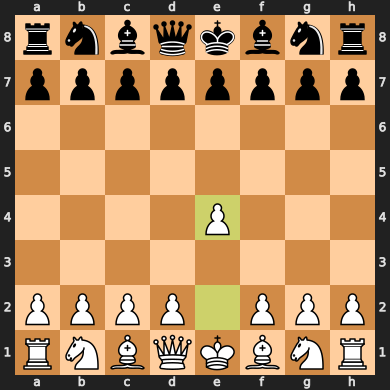

AI's turn
e2e4


IllegalMoveError: ignored

In [ ]:
import chess
from IPython.display import display, clear_output

def output_to_move(source_output, dest_output):
    source_square = torch.argmax(source_output).item()
    dest_square = torch.argmax(dest_output).item()
    return reverse_cache[source_square] + reverse_cache[dest_square]


def interactive_game():
    board = chess.Board()

    while not board.is_game_over():
        clear_output(wait=True)
        display(board)

        

        if board.turn == chess.WHITE:
            # Get user input
            move = "e2e4"
        else:
            # AI's turn
            print("AI's turn")

            # Convert board state to model input
            input_tensor = board_to_tensor(board)
        
            # Get the move from the model
            source_output, dest_output = model(input_tensor.to(device))
        
            # Convert model output to move
            move = output_to_move(source_output, dest_output)
            print(move)
        
        # Make the move on the board
        board.push_san(move)

        if board.turn == chess.WHITE:
            break

    clear_output(wait=True)
    display(board)
    print("Game over")

interactive_game()
